In [36]:
# Data Processing
import numpy as np
from sklearn.preprocessing import LabelEncoder, normalize, StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot as plt
import pandas as pd

train_data = np.genfromtxt('trainData.csv', delimiter=',', dtype=str)
m = train_data.shape[0] - 1
d = train_data.shape[1] - 1
print(m, d)
train_input_raw, train_output = train_data[1:,0:d].tolist(), train_data[1:,d].tolist()

24712 19


The above step uses `numpy`'s `genfromtxt` function since there are no missing values. Below I randomly print to get the actual types of data like textual information and specific fields

In [37]:
print([train_input_raw[0], train_output[0]])

[['28', '"admin."', '"single"', '"university.degree"', '"no"', '"yes"', '"no"', '"cellular"', '"aug"', '"mon"', '1', '999', '0', '"nonexistent"', '-2.9', '92.201', '-31.4', '0.861', '5076.2'], '1']


#### Preprocessing step 1: 
Remove quotes in textual information

#### Preprocessing step 2:
Convert numeric information to numbers as opposed to within single quotes. These fields are `0, 10, 11, 12, 14, ..., 19`.

In [38]:
for i in range(0, m):
    for j in range(0, d-1):
        if train_input_raw[i][j].find("\"") != -1:
            train_input_raw[i][j] = train_input_raw[i][j][1:-1] # removing double quotes in pairs
        else:
            train_input_raw[i][j] = float(train_input_raw[i][j])
    train_output[i] = float(train_output[i])
train_output = np.array(train_output).astype(float)

print(train_input_raw[0])
print(train_output[0])

[28.0, 'admin.', 'single', 'university.degree', 'no', 'yes', 'no', 'cellular', 'aug', 'mon', 1.0, 999.0, 0.0, 'nonexistent', -2.9, 92.201, -31.4, 0.861, '5076.2']
1.0


Now that the preprocessing has been completed, it is time to separate the input and outputs and begin training. Clearly, we might have to go with Ensemble methods since the data has both textual and numeric information in it.

In [39]:
rand_index = np.random.randint(low=0, high=m)
print(train_input_raw[rand_index])
print(train_output[rand_index])

[30.0, 'technician', 'married', 'university.degree', 'no', 'no', 'yes', 'telephone', 'jun', 'mon', 5.0, 999.0, 0.0, 'nonexistent', 1.4, 94.465, -41.8, 4.865, '5228.1']
0.0


Now that I have the data through a simple level of preprocessing, I am going to convert text data into numeric values. For this I am first going to tokenize and then merge this into the actual training input.

#### Preprocessing step 3:
Convert the text data into numbers using `LabelEncoder`.

In [40]:
train_text_data = np.hstack((np.array(train_input_raw)[:,1:10], np.array(train_input_raw)[:,13:1]))
print('Size of training text data : {0}'.format(train_text_data.shape))

# Converting the textual data into one vector per training input
train_text_vectors = []

for j in range(0, train_text_data.shape[1]):
    lbl_enc = LabelEncoder()
    train_text_vectors.append(lbl_enc.fit_transform(train_text_data[:,j]))
train_text_vectors = np.array(train_text_vectors).T

print('Size of training text data: {0}'.format(train_text_vectors.shape))
print('Text: {0} --> Data: {1}'.format(train_text_data[0], train_text_vectors[0]))
print('Text: {0} --> Data: {1}'.format(train_text_data[10], train_text_vectors[10]))

Size of training text data : (24712, 9)
Size of training text data: (24712, 9)
Text: ['admin.' 'single' 'university.degree' 'no' 'yes' 'no' 'cellular' 'aug'
 'mon'] --> Data: [0 2 6 0 2 0 0 1 1]
Text: ['blue-collar' 'single' 'basic.9y' 'no' 'yes' 'no' 'cellular' 'jul' 'tue'] --> Data: [1 2 2 0 2 0 0 3 3]


Now I am going to make five versions of the dataset
+ Unnormalized
+ Normalized
+ Feature Scaled
+ Feature Scaled + Normalized
+ One Hot Encoded text + Normalized

I use the `OneHotEncoder` to encode categorical data after encoding using label as shown [here](http://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features).

In [41]:
# Version 1
train_input_1 = np.hstack((np.array(train_input_raw)[:,0:1], 
                         train_text_vectors[:,0:train_text_vectors.shape[1] - 1], 
                         np.array(train_input_raw)[:,10:13],
                         train_text_vectors[:,train_text_vectors.shape[1] - 1].reshape(-1, 1),
                         np.array(train_input_raw)[:,14:]
                        )).astype(float)
print("Version 1: Shape {0}".format(train_input_1.shape))
print('Vector = {0}: \nNorm = {1}'.format(train_input_1[rand_index], np.linalg.norm(train_input_1[rand_index])))

# Version 2
train_input_2 = normalize(train_input_1)
print("Version 2: Shape {0}".format(train_input_2.shape))
print('Vector = {0}: \nNorm = {1}'.format(train_input_2[rand_index], np.linalg.norm(train_input_2[rand_index])))

# Version 3
mean_reduce = StandardScaler()
train_input_3 = mean_reduce.fit_transform(train_input_1)
print("Version 3: Shape {0}".format(train_input_3.shape))
print('Vector = {0}: \nNorm = {1}'.format(train_input_3[rand_index], np.linalg.norm(train_input_3[rand_index])))

# Version 4
train_input_4 = normalize(train_input_3)
print(train_input_4.shape)
print("Version 4: Shape {0}".format(train_input_4.shape))
print('Vector = {0}: \nNorm = {1}'.format(train_input_4[rand_index], np.linalg.norm(train_input_4[rand_index])))

# Version 5
ohe = OneHotEncoder()
ohe.fit(train_text_vectors)
train_text_ohe_vectors = ohe.transform(train_text_vectors).toarray()
print(train_text_ohe_vectors[0])

train_input_5 = np.hstack((np.array(train_input_raw)[:,0:1],
                         np.array(train_input_raw)[:,10:13],
                         np.array(train_input_raw)[:,14:],
                         train_text_ohe_vectors
                         )).astype(float)
train_input_5 = normalize(train_input_5)
print("Version 5: Shape {0}".format(train_input_5.shape))
print('Vector = {0}: \nNorm = {1}'.format(train_input_5[rand_index], np.linalg.norm(train_input_5[rand_index])))

train_input = (train_input_1, train_input_2, train_input_3, train_input_4, train_input_5)

Version 1: Shape (24712, 18)
Vector = [  3.00000000e+01   9.00000000e+00   1.00000000e+00   6.00000000e+00
   0.00000000e+00   0.00000000e+00   2.00000000e+00   1.00000000e+00
   4.00000000e+00   5.00000000e+00   9.99000000e+02   0.00000000e+00
   1.00000000e+00   1.40000000e+00   9.44650000e+01  -4.18000000e+01
   4.86500000e+00   5.22810000e+03]: 
Norm = 5323.794897857167
Version 2: Shape (24712, 18)
Vector = [  5.63507809e-03   1.69052343e-03   1.87835936e-04   1.12701562e-03
   0.00000000e+00   0.00000000e+00   3.75671873e-04   1.87835936e-04
   7.51343746e-04   9.39179682e-04   1.87648100e-01   0.00000000e+00
   1.87835936e-04   2.62970311e-04   1.77439217e-02  -7.85154214e-03
   9.13821831e-04   9.82025059e-01]: 
Norm = 1.0
Version 3: Shape (24712, 18)
Vector = [-0.95978953  1.46353836 -0.28071125  1.05604046 -0.51183526 -1.08812951
  2.32513886  1.32024041 -0.09248411  0.87273656  0.19653049 -0.35249416
 -0.70973465  0.83872146  1.53859821 -0.27803682  0.71650221  0.84468804]: 


Now the preprocessing steps are completed. I will try my preprocessed dataset on multiple methods of classification.
For this, I will generate 5 folds (stratified) and use 5-fold cross validation to get the best method. Folds should be invariant, hence I will use `train_input_1` and its output to generate the `folds` list.

In [ ]:
skf = StratifiedKFold(n_splits=5)
folds = []
for tr_split, va_split in skf.split(train_input_1, train_output):
    folds.append((tr_split, va_split))
for i in range(0, len(folds)):
    print("Fold {0}\tTrain number: {1} Validation number: {2}".format(i+1, len(folds[i][0]), len(folds[i][1])))

### Attempt 1: SVM with Gaussian Kernel with 5 fold cross validation on all versions

In [ ]:
for v in range(0, 5):
    accu_train = prec_train = rcll_train = auc_train = 0.0
    accu_valid = prec_valid = rcll_valid = auc_valid = 0.0
    g_svm = SVC(kernel='rbf', cache_size=2000)
    for i in range(0, len(folds)):
        print("Performing fold {0}".format(i+1))
        g_svm.fit(train_input[v][folds[i][0]], train_output[folds[i][0]])

        train_pred = g_svm.predict(train_input[v][folds[i][0]])
        valid_pred = g_svm.predict(train_input[v][folds[i][1]])

        accu_train += accuracy_score(train_output[folds[i][0]], train_pred)
        prec_train += precision_score(train_output[folds[i][0]], train_pred)
        rcll_train += recall_score(train_output[folds[i][0]], train_pred)
        auc_train += roc_auc_score(train_output[folds[i][0]], train_pred)
    
        accu_valid += accuracy_score(train_output[folds[i][1]], valid_pred)
        prec_valid += precision_score(train_output[folds[i][1]], valid_pred)
        rcll_valid += recall_score(train_output[folds[i][1]], valid_pred)
        auc_valid += roc_auc_score(train_output[folds[i][1]], valid_pred)
    
    print("Average training accuracy after {0} fold cross validation = {1}".format(len(folds), accu_train/len(folds)))
    print("Average training precision after {0} fold cross validation = {1}".format(len(folds), prec_train/len(folds)))
    print("Average training recall after {0} fold cross validation = {1}".format(len(folds), rcll_train/len(folds)))
    print("Average training AUC-ROC after {0} fold cross validation = {1}".format(len(folds), auc_train/len(folds)))

    print("Average validation accuracy after {0} fold cross validation = {1}".format(len(folds), accu_valid/len(folds)))
    print("Average validation precision after {0} fold cross validation = {1}".format(len(folds), prec_valid/len(folds)))
    print("Average validation recall after {0} fold cross validation = {1}".format(len(folds), rcll_valid/len(folds)))
    print("Average validation AUC-ROC after {0} fold cross validation = {1}\n".format(len(folds), auc_valid/len(folds)))

### Attempt 2: Random Forests with multiple number of trees and 10 fold cross validation for all versions

In [ ]:
for v in range(0, 5):
    for m in range(3, 8):
        accu_train = prec_train = rcll_train = auc_train = 0.0
        accu_valid = prec_valid = rcll_valid = auc_valid = 0.0
        rnd_frst = RandomForestClassifier(n_estimators=m)
        for i in range(0, len(folds)):
            print("Performing fold {0}".format(i+1))
            rnd_frst.fit(train_input[v][folds[i][0]], train_output[folds[i][0]])

            train_pred = rnd_frst.predict(train_input[v][folds[i][0]])
            valid_pred = rnd_frst.predict(train_input[v][folds[i][1]])

            accu_train += accuracy_score(train_output[folds[i][0]], train_pred)
            prec_train += precision_score(train_output[folds[i][0]], train_pred)
            rcll_train += recall_score(train_output[folds[i][0]], train_pred)
            auc_train += roc_auc_score(train_output[folds[i][0]], train_pred)
    
            accu_valid += accuracy_score(train_output[folds[i][1]], valid_pred)
            prec_valid += precision_score(train_output[folds[i][1]], valid_pred)
            rcll_valid += recall_score(train_output[folds[i][1]], valid_pred)
            auc_valid += roc_auc_score(train_output[folds[i][1]], valid_pred)
    
        print("Average training accuracy after {0} fold cross validation = {1} with m = {2}".format(len(folds), accu_train/len(folds), m))
        print("Average training precision after {0} fold cross validation = {1} with m = {2}".format(len(folds), prec_train/len(folds), m))
        print("Average training recall after {0} fold cross validation = {1} with m = {2}".format(len(folds), rcll_train/len(folds), m))
        print("Average training AUC-ROC after {0} fold cross validation = {1} with m = {2}".format(len(folds), auc_train/len(folds), m))

        print("Average validation accuracy after {0} fold cross validation = {1} with m = {2}".format(len(folds), accu_valid/len(folds), m))
        print("Average validation precision after {0} fold cross validation = {1} with m = {2}".format(len(folds), prec_valid/len(folds), m))
        print("Average validation recall after {0} fold cross validation = {1} with m = {2}".format(len(folds), rcll_valid/len(folds), m))
        print("Average validation AUC-ROC after {0} fold cross validation = {1} with m = {2}".format(len(folds), auc_valid/len(folds), m))

### Attempt 3: AdaBoost with multiple weak classifiers and 10 fold cross validation

In [ ]:
for v in range(0, 5):
    for m in [10, 25, 50, 100, 200, 250, 500, 1000]:
        accu_train = prec_train = rcll_train = auc_train = 0.0
        accu_valid = prec_valid = rcll_valid = auc_valid = 0.0
        adaboost = AdaBoostClassifier(n_estimators=m)
        for i in range(0, len(folds)):
            print("Performing fold {0}".format(i+1))
            adaboost.fit(train_input[v][folds[i][0]], train_output[folds[i][0]])

            train_pred = adaboost.predict(train_input[v][folds[i][0]])
            valid_pred = adaboost.predict(train_input[v][folds[i][1]])

            accu_train += accuracy_score(train_output[folds[i][0]], train_pred)
            prec_train += precision_score(train_output[folds[i][0]], train_pred)
            rcll_train += recall_score(train_output[folds[i][0]], train_pred)
            auc_train += roc_auc_score(train_output[folds[i][0]], train_pred)
    
            accu_valid += accuracy_score(train_output[folds[i][1]], valid_pred)
            prec_valid += precision_score(train_output[folds[i][1]], valid_pred)
            rcll_valid += recall_score(train_output[folds[i][1]], valid_pred)
            auc_valid += roc_auc_score(train_output[folds[i][1]], valid_pred)
    
        print("Average training accuracy after {0} fold cross validation = {1} with m = {2}".format(len(folds), accu_train/len(folds), m))
        print("Average training precision after {0} fold cross validation = {1} with m = {2}".format(len(folds), prec_train/len(folds), m))
        print("Average training recall after {0} fold cross validation = {1} with m = {2}".format(len(folds), rcll_train/len(folds), m))
        print("Average training AUC-ROC after {0} fold cross validation = {1} with m = {2}".format(len(folds), auc_train/len(folds), m))

        print("Average validation accuracy after {0} fold cross validation = {1} with m = {2}".format(len(folds), accu_valid/len(folds), m))
        print("Average validation precision after {0} fold cross validation = {1} with m = {2}".format(len(folds), prec_valid/len(folds), m))
        print("Average validation recall after {0} fold cross validation = {1} with m = {2}".format(len(folds), rcll_valid/len(folds), m))
        print("Average validation AUC-ROC after {0} fold cross validation = {1} with m = {2}".format(len(folds), auc_valid/len(folds), m))

### Attempt 4: Gaussian Naive Bayes with 5 fold cross validation on all versions

In [ ]:
for v in range(0, 5):
    accu_train = prec_train = rcll_train = auc_train = 0.0
    accu_valid = prec_valid = rcll_valid = auc_valid = 0.0
    gnb = GaussianNB()
    for i in range(0, len(folds)):
        print("Performing fold {0}".format(i+1))
        gnb.fit(train_input[v][folds[i][0]], train_output[folds[i][0]])

        train_pred = gnb.predict(train_input[v][folds[i][0]])
        valid_pred = gnb.predict(train_input[v][folds[i][1]])

        accu_train += accuracy_score(train_output[folds[i][0]], train_pred)
        prec_train += precision_score(train_output[folds[i][0]], train_pred)
        rcll_train += recall_score(train_output[folds[i][0]], train_pred)
        auc_train += roc_auc_score(train_output[folds[i][0]], train_pred)
    
        accu_valid += accuracy_score(train_output[folds[i][1]], valid_pred)
        prec_valid += precision_score(train_output[folds[i][1]], valid_pred)
        rcll_valid += recall_score(train_output[folds[i][1]], valid_pred)
        auc_valid += roc_auc_score(train_output[folds[i][1]], valid_pred)
    
    print("Average training accuracy after {0} fold cross validation = {1}".format(len(folds), accu_train/len(folds)))
    print("Average training precision after {0} fold cross validation = {1}".format(len(folds), prec_train/len(folds)))
    print("Average training recall after {0} fold cross validation = {1}".format(len(folds), rcll_train/len(folds)))
    print("Average training AUC-ROC after {0} fold cross validation = {1}".format(len(folds), auc_train/len(folds)))

    print("Average validation accuracy after {0} fold cross validation = {1}".format(len(folds), accu_valid/len(folds)))
    print("Average validation precision after {0} fold cross validation = {1}".format(len(folds), prec_valid/len(folds)))
    print("Average validation recall after {0} fold cross validation = {1}".format(len(folds), rcll_valid/len(folds)))
    print("Average validation AUC-ROC after {0} fold cross validation = {1}\n".format(len(folds), auc_valid/len(folds)))

### Attempt 5: K-NN with 5 fold cross validation on all versions and multiple choices of k

In [ ]:
for v in range(0, 5):
    for k in [10, 25, 50, 100, 200, 250, 500, 1000]:
        accu_train = prec_train = rcll_train = auc_train = 0.0
        accu_valid = prec_valid = rcll_valid = auc_valid = 0.0
        knn_clf = KNeighborsClassifier(n_neighbors=k)
        for i in range(0, len(folds)):
            print("Performing fold {0}".format(i+1))
            knn_clf.fit(train_input[v][folds[i][0]], train_output[folds[i][0]])

            train_pred = knn_clf.predict(train_input[v][folds[i][0]])
            valid_pred = knn_clf.predict(train_input[v][folds[i][1]])

            accu_train += accuracy_score(train_output[folds[i][0]], train_pred)
            prec_train += precision_score(train_output[folds[i][0]], train_pred)
            rcll_train += recall_score(train_output[folds[i][0]], train_pred)
            auc_train += roc_auc_score(train_output[folds[i][0]], train_pred)
    
            accu_valid += accuracy_score(train_output[folds[i][1]], valid_pred)
            prec_valid += precision_score(train_output[folds[i][1]], valid_pred)
            rcll_valid += recall_score(train_output[folds[i][1]], valid_pred)
            auc_valid += roc_auc_score(train_output[folds[i][1]], valid_pred)
    
        print("Average training accuracy after {0} fold cross validation = {1} with k = {2}".format(len(folds), accu_train/len(folds), k))
        print("Average training precision after {0} fold cross validation = {1} with k = {2}".format(len(folds), prec_train/len(folds), k))
        print("Average training recall after {0} fold cross validation = {1} with k = {2}".format(len(folds), rcll_train/len(folds), k))
        print("Average training AUC-ROC after {0} fold cross validation = {1} with k = {2}".format(len(folds), auc_train/len(folds), k))

        print("Average validation accuracy after {0} fold cross validation = {1} with k = {2}".format(len(folds), accu_valid/len(folds), k))
        print("Average validation precision after {0} fold cross validation = {1} with k = {2}".format(len(folds), prec_valid/len(folds), k))
        print("Average validation recall after {0} fold cross validation = {1} with k = {2}".format(len(folds), rcll_valid/len(folds), k))
        print("Average validation AUC-ROC after {0} fold cross validation = {1} with k = {2}".format(len(folds), auc_valid/len(folds), k))

### Submission 1: Based on Gaussian Naive Bayes and version 4 of the dataset

In [ ]:
test_input_raw = np.genfromtxt('testData.csv', delimiter=',', dtype=str)[1:,1:].tolist()
for i in range(0, len(test_input_raw)):
    for j in range(0, d-1):
        if test_input_raw[i][j].find("\"") != -1:
            test_input_raw[i][j] = test_input_raw[i][j][1:-1] # removing double quotes in pairs
        else:
            test_input_raw[i][j] = float(test_input_raw[i][j])

test_text_data = np.hstack((np.array(test_input_raw)[:,1:10], np.array(test_input_raw)[:,13:1]))
print('Size of testing text data : {0}'.format(test_text_data.shape))

# Converting the textual data into one vector per training input
test_text_vectors = []

for j in range(0, test_text_data.shape[1]):
    lbl_enc = LabelEncoder()
    lbl_enc.fit(train_text_data[:,j])
    test_text_vectors.append(lbl_enc.transform(test_text_data[:,j]))
test_text_vectors = np.array(test_text_vectors).T

print('Size of testing text data: {0}'.format(test_text_vectors.shape))
print('Text: {0} --> Data: {1}'.format(test_text_data[0], test_text_vectors[0]))
print('Text: {0} --> Data: {1}'.format(test_text_data[10], test_text_vectors[10]))

test_input_sub_1 = np.hstack((np.array(test_input_raw)[:,0:1], 
                         test_text_vectors[:,0:test_text_vectors.shape[1] - 1], 
                         np.array(test_input_raw)[:,10:13],
                         test_text_vectors[:,test_text_vectors.shape[1] - 1].reshape(-1, 1),
                         np.array(test_input_raw)[:,14:]
                        )).astype(float)

test_input_sub_1 = mean_reduce.transform(test_input_sub_1)
test_input_sub_1 = normalize(test_input_sub_1)
print("Submission 1: Shape {0}".format(test_input_sub_1.shape))
print('Vector = {0}: \nNorm = {1}'.format(test_input_sub_1[10], np.linalg.norm(test_input_sub_1[10])))

sub_file = open('sub_1.csv','w')
sub_file.write('Id,Class\n')
gnb = GaussianNB()
gnb.fit(train_input_4, train_output)
sub_1_preds = gnb.predict(test_input_sub_1)
for i in range(0, len(sub_1_preds)):
    sub_file.write('{0},{1}\n'.format(i+1, int(sub_1_preds[i])))
sub_file.close()

I think it is time to find out feature importances:
+ Contact will not affect a lot I guess
+ Group data in same months (Jan, Feb, ..., Nov, Dec). Now run classifiers on each one of them and test using appropriate classifer for the test data. This is some idea taken from time series data
+ Group ages. The behaviour in different age groups might be different.

In [7]:
month_counter = np.zeros((12, 2))
month_dict = {'jan': 0, 'feb': 1, 'mar': 2, 'apr': 3, 'may': 4, 'jun': 5, 'jul': 6, 'aug': 7, 'sep': 8, 'oct': 9, 'nov': 10, 'dec': 11}
contact_counter = np.zeros((2, 2))
for i in range(0, m):
    month_counter[month_dict[train_input_raw[i][8]], int(train_output[i])] += 1
    if train_input_raw[i][7] == 'cellular':
        contact_counter[0][int(train_output[i])] += 1
    else:
        contact_counter[1][int(train_output[i])] += 1

for i in range(0, 12):
    key = list(month_dict.keys())[list(month_dict.values()).index(i)]
    print('{0}-->{1}'.format(key, month_counter[i]))
    
print('Cellular-->{0}'.format(contact_counter[0]))
print('Telephone-->{0}'.format(contact_counter[1]))

jan-->[ 0.  0.]
feb-->[ 0.  0.]
mar-->[ 156.  169.]
apr-->[ 1267.   339.]
may-->[ 7710.   551.]
jun-->[ 2836.   323.]
jul-->[ 3976.   375.]
aug-->[ 3326.   397.]
sep-->[ 191.  155.]
oct-->[ 222.  177.]
nov-->[ 2186.   246.]
dec-->[ 58.  52.]
Cellular-->[ 13376.   2327.]
Telephone-->[ 8552.   457.]


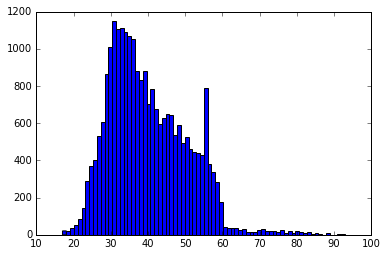

[ 649 6038 7618 4519 3761 1699  166  159   85   18] --> counts
[ 17.   24.7  32.4  40.1  47.8  55.5  63.2  70.9  78.6  86.3  94. ] --> bin edges


In [8]:
plt.hist(train_input_1[:,0], bins='auto')
plt.show()
hist, bin_edges = np.histogram(train_input_1[:,0])
print('{0} --> counts'.format(hist))
print('{0} --> bin edges'.format(bin_edges))

A few inferences:
+ People who are contacted by cellphone subscribe 1 in approximately 8, whereas people who are contacted by telephone subscribe 1 in almost 19
+ People in the age group 25 to 40 are contacted the most
+ There are no people contacted in Jan and Feb and most people are contacted in May

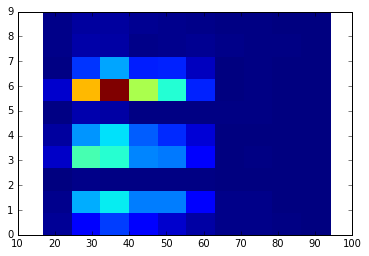

In [9]:
hist2d, xedge, yedge = np.histogram2d(train_input_1[:,0], train_input_1[:,8])
hist2d = hist2d.T
fig = plt.figure()
ax = fig.add_subplot(111)
X, Y = np.meshgrid(xedge, yedge)
ax.pcolormesh(X, Y, hist2d)
plt.show()

I believe the input data is generated from a mixture of Gaussians (note the 3 spots in the 2D histogram). I am going to now train 12 classifiers. Each classifier will perform for each month of the year. Note that January and February are not in the dataset, hence we will train the classifiers for January and February based on December and March, weighing more on the data obtained in December and March respectively. 

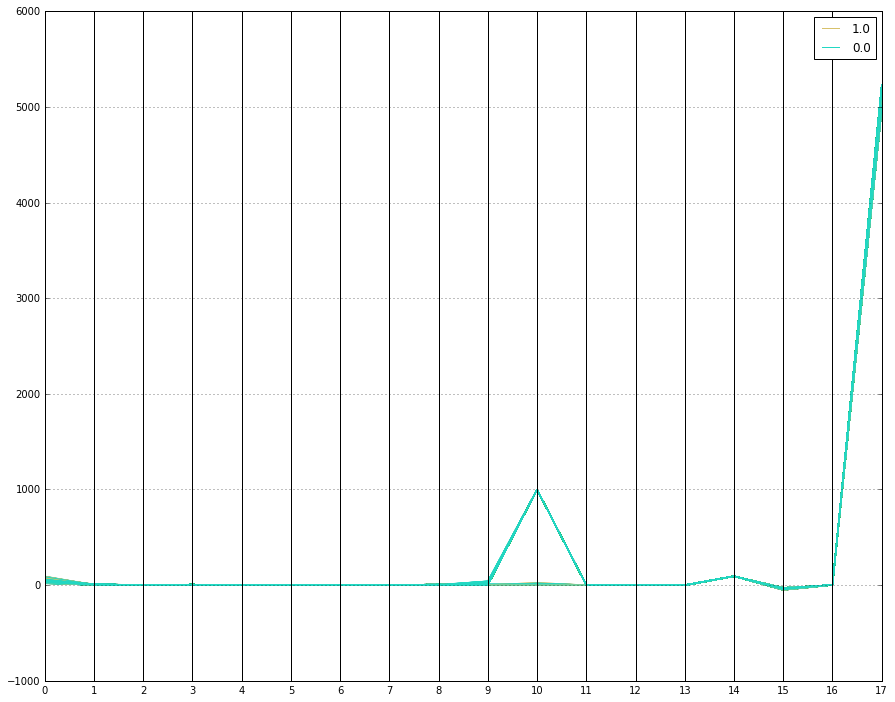

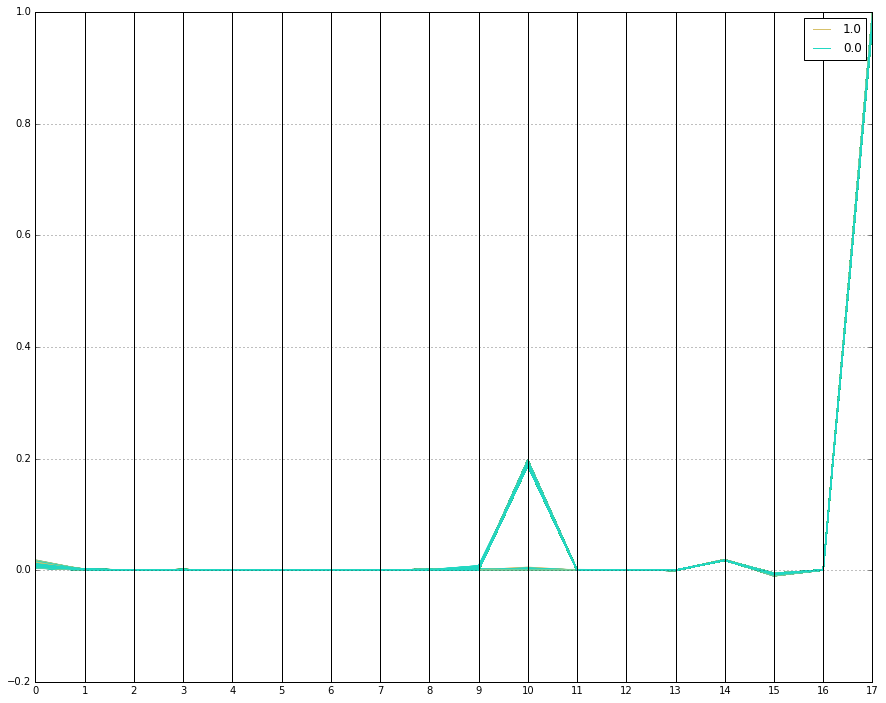

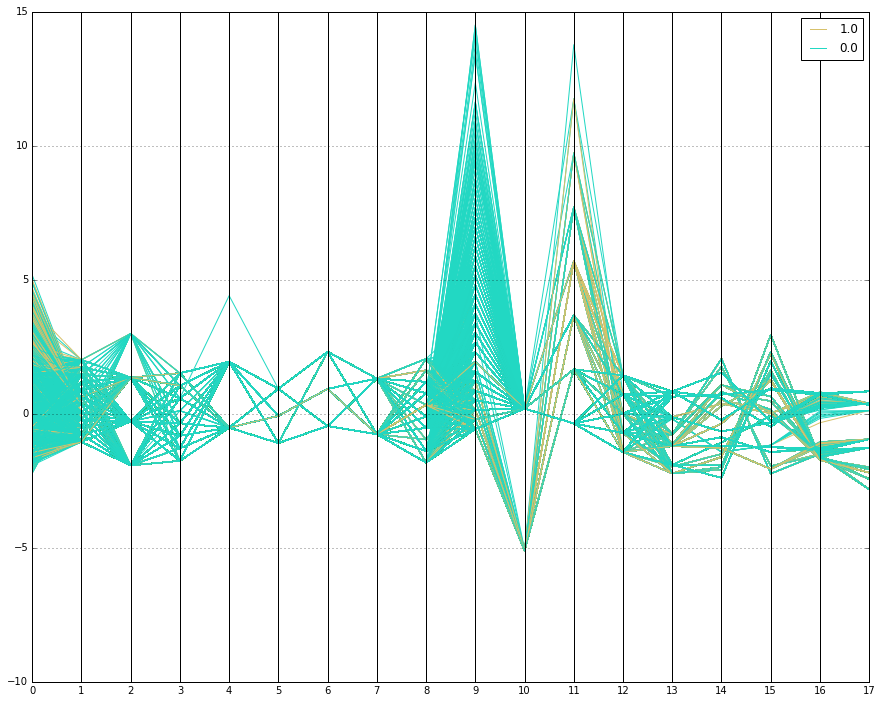

In [53]:
df_tr_1 = pd.DataFrame(train_input_1)
df_tr_1['Y'] = pd.Series(train_output, index=df_tr_1.index)

plt.figure(figsize=(15, 12))
pd.tools.plotting.parallel_coordinates(df_tr_1, 'Y')
plt.show()

df_tr_2 = pd.DataFrame(train_input_2)
df_tr_2['Y'] = pd.Series(train_output, index=df_tr_2.index)

plt.figure(figsize=(15, 12))
pd.tools.plotting.parallel_coordinates(df_tr_2, 'Y')
plt.show()

df_tr_3 = pd.DataFrame(train_input_3)
df_tr_3['Y'] = pd.Series(train_output, index=df_tr_3.index)

plt.figure(figsize=(15, 12))
pd.tools.plotting.parallel_coordinates(df_tr_3, 'Y')
plt.show()